In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [287]:
ratings_data = pd.read_csv('ml-latest-small/ratings.csv')
movies_data = pd.read_csv('ml-latest-small/movies.csv')

In [288]:
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [289]:
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [290]:
movies_data.genres = movies_data.genres.str.split('|')
movies_data.genres

0       [Adventure, Animation, Children, Comedy, Fantasy]
1                          [Adventure, Children, Fantasy]
2                                       [Comedy, Romance]
3                                [Comedy, Drama, Romance]
4                                                [Comedy]
                              ...                        
9737                 [Action, Animation, Comedy, Fantasy]
9738                         [Animation, Comedy, Fantasy]
9739                                              [Drama]
9740                                  [Action, Animation]
9741                                             [Comedy]
Name: genres, Length: 9742, dtype: object

In [291]:
genre_list = ["Action","Adventure","Animation","Children","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western", "IMAX", "(no genres listed)"]

In [292]:
movies_data[genre_list] = 0

In [293]:
for idx, row in movies_data.iterrows():
    for genre in row.genres:
        movies_data.loc[idx, genre] = 1
movies_data.drop('genres',axis=1, inplace=True)

In [294]:
movies_data.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,IMAX,(no genres listed)
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [295]:
ratings_with_movies = ratings_data.join(movies_data.set_index('movieId'), on='movieId').drop('timestamp',axis=1)
ratings_with_movies.head()

,userId,movieId,rating,title,Action,Adventure,Animation,Children,Comedy,Crime,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,IMAX,(no genres listed)
0,1,1,4.0,Toy Story (1995),0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,Grumpier Old Men (1995),0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,1,6,4.0,Heat (1995),1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,1,50,5.0,"Usual Suspects, The (1995)",0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0


In [296]:
user_data = pd.DataFrame(columns = genre_list, index=ratings_with_movies['userId'].unique())
for genre in genre_list:
    user_data[genre] = ratings_with_movies[ratings_with_movies[genre]==1].groupby('userId').mean().rating

user_data['avg_rating'] = user_data.mean(axis=1)
user_data = user_data.fillna(0)
user_data.index.name = 'userId'
user_data.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,IMAX,(no genres listed),avg_rating
userId,,,,,,,,,,,,,,,,,,,,,
1,4.322222,4.388235,4.689655,4.547619,4.277108,4.355556,0.000000,4.529412,4.297872,5.0,...,4.681818,4.166667,4.307692,4.225000,4.145455,4.500000,4.285714,0.000000,0.0,4.364154
2,3.954545,4.166667,0.000000,0.000000,4.000000,3.800000,4.333333,3.882353,0.000000,0.0,...,0.000000,4.000000,4.500000,3.875000,3.700000,4.500000,3.500000,3.750000,0.0,3.925850
3,3.571429,2.727273,0.500000,0.500000,1.000000,0.500000,0.000000,0.750000,3.375000,0.0,...,0.500000,5.000000,0.500000,4.200000,4.142857,0.500000,0.000000,0.000000,0.0,2.163604
4,3.320000,3.655172,4.000000,3.800000,3.509615,3.814815,4.000000,3.483333,3.684211,4.0,...,4.000000,3.478261,3.379310,2.833333,3.552632,3.571429,3.800000,3.000000,0.0,3.638532
5,3.111111,3.250000,4.333333,4.111111,3.466667,3.833333,0.000000,3.800000,4.142857,0.0,...,4.400000,4.000000,3.090909,2.500000,3.555556,3.333333,3.000000,3.666667,0.0,3.564405


In [297]:
movies_data = movies_data.set_index('movieId')
movies_data['avg_rating'] = ratings_with_movies.groupby('movieId').mean().rating
movies_data.head()

,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,IMAX,(no genres listed),avg_rating
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3.920930
2,Jumanji (1995),0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3.431818
3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,3.259615
4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,2.357143
5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.071429


In [298]:
y_pd = pd.DataFrame(index=user_data.index, columns=movies_data.index)
for idx, row in ratings_with_movies.iterrows():
    y_pd.loc[row.userId,row.movieId] = row.rating

In [299]:
y_pd.shape

(610, 9742)

In [300]:
user_data.tail()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,IMAX,(no genres listed),avg_rating
userId,,,,,,,,,,,,,,,,,,,,,
606,3.178808,3.503401,3.714286,3.448980,3.565321,3.654135,3.8,3.787966,3.597938,3.8125,...,3.727273,3.791209,3.740845,3.556962,3.525126,3.792308,3.411765,3.062500,0.0,3.579867
607,3.722222,3.466667,3.333333,3.421053,3.327273,3.814815,0.0,4.012195,3.571429,0.0000,...,3.600000,4.647059,3.517241,3.250000,4.114754,4.166667,4.000000,5.000000,0.0,3.828176
608,3.330325,3.220994,3.118182,2.460227,2.736620,3.613014,3.0,3.437500,3.000000,3.7500,...,2.757576,3.550725,2.886792,3.296407,3.536680,3.578947,2.636364,4.000000,0.0,3.222628
609,3.090909,3.200000,3.000000,3.000000,3.285714,3.500000,3.0,3.368421,3.000000,0.0000,...,0.000000,0.000000,3.200000,3.000000,3.285714,3.500000,4.000000,3.000000,0.0,3.245672
610,3.600580,3.705993,3.901515,3.651786,3.731144,3.800366,4.2,3.874739,3.592715,4.3500,...,3.928571,3.766667,3.731092,3.659363,3.573529,3.776596,3.742424,3.628049,0.0,3.774828


In [301]:
y_pd.tail()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
609,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
610,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [302]:
count=0
while user_data.shape[0]<movies_data.shape[0] and count < 30:
    count+=1
    user_data = pd.concat([user_data,user_data], axis=0)
    y_pd = pd.concat([y_pd,y_pd],axis=0)
    print(count)
user_data = user_data[:movies_data.shape[0]]
y_pd = y_pd.iloc[:movies_data.shape[0]].fillna(0)

1
2
3
4


In [303]:
y_scaler = MinMaxScaler((0,1))

scaled_movie_data = movies_data.drop('title',axis=1).apply(lambda x: round(x*10))
scaled_user_data = user_data.apply(lambda x: round(x*10))
scaled_y = y_scaler.fit(y_pd).transform(y_pd)

In [304]:
scaled_user_data.max().max()

50.0

In [305]:
scaled_movie_data.max().max()

50.0

In [306]:
movie_train, movie_test = train_test_split(scaled_movie_data, test_size=0.2)
user_train, user_test = train_test_split(scaled_user_data,  test_size=0.2)
y_train, y_test = train_test_split(scaled_y, test_size=0.2)

In [307]:
movie_model = tf.keras.models.Sequential([
    #tf.keras.layers.Embedding(input_dim = 51, output_dim = 64, input_length=21),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32),
])

user_model = tf.keras.models.Sequential([
    #tf.keras.layers.Embedding(input_dim = 51, output_dim= 64, input_length=21),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32),
])

movie_input = tf.keras.layers.Input(shape=scaled_movie_data.shape[1])
movie_output = movie_model(movie_input)
movie_output = tf.keras.layers.Reshape((32,1))(movie_output)
#movie_output = tf.linalg.l2_normalize(movie_output)

user_input = tf.keras.layers.Input(shape=scaled_user_data.shape[1])
user_output = user_model(user_input)
user_output = tf.keras.layers.Reshape((32,1))(user_output)
#user_output = tf.linalg.l2_normalize(user_output, axis=1)

output = tf.linalg.matmul(user_output, movie_output, transpose_a=True)
output = tf.keras.activations.sigmoid(output)

model = tf.keras.Model([movie_input, user_input],output)

model.summary()

Model: "model_47"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_126 (InputLayer)         [(None, 21)]         0           []                               
                                                                                                  
 input_125 (InputLayer)         [(None, 21)]         0           []                               
                                                                                                  
 sequential_128 (Sequential)    (None, 32)           42656       ['input_126[0][0]']              
                                                                                                  
 sequential_127 (Sequential)    (None, 32)           42656       ['input_125[0][0]']              
                                                                                           

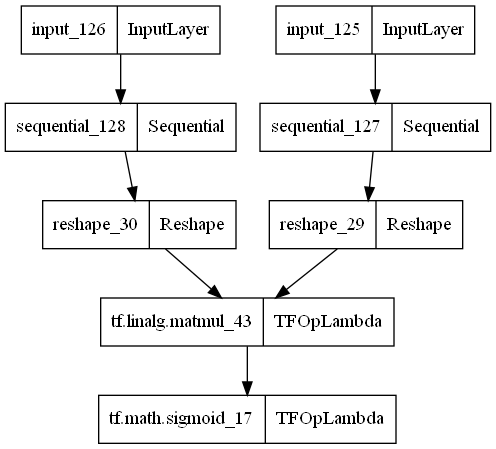

In [308]:
tf.keras.utils.plot_model(model)

In [310]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy'])

In [312]:
model.fit([movie_train, user_train], y_train[:, :7793].diagonal(), epochs=3 )

Epoch 1/3
244/244 [==============================] - 3s 9ms/step - loss: nan - accuracy: 0.9753
Epoch 2/3
244/244 [==============================] - 2s 9ms/step - loss: nan - accuracy: 0.9820
Epoch 3/3
244/244 [==============================] - 2s 8ms/step - loss: nan - accuracy: 0.9820


In [313]:
a = model.predict([movie_test, user_test])

61/61 [==============================] - 0s 3ms/step


In [320]:
a

array([[[nan]],

       [[nan]],

       [[nan]],

       ...,

       [[nan]],

       [[nan]],

       [[nan]]], dtype=float32)

In [314]:
model.evaluate([movie_test, user_test], y_test.diagonal())

61/61 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.9579


[nan, 0.9579271674156189]

In [315]:
print(movie_train.shape, user_train.shape, y_train.shape)

(7793, 21) (7793, 21) (7793, 9742)


In [316]:
movie_train[:5]

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,IMAX,(no genres listed),avg_rating
movieId,,,,,,,,,,,,,,,,,,,,,
5011,0,0,0,0,0,0,0,10,0,0,...,0,0,10,0,0,0,0,0,0,38.0
128852,0,0,0,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,38.0
1031,0,10,0,10,0,0,0,0,0,0,...,10,0,0,0,0,0,0,0,0,35.0
127136,0,0,0,0,0,0,0,10,0,0,...,0,10,0,0,10,0,0,0,0,32.0
63853,0,10,0,0,0,0,0,10,0,0,...,0,0,0,0,0,10,10,0,0,32.0


In [317]:
user_train[:5]

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,IMAX,(no genres listed),avg_rating
userId,,,,,,,,,,,,,,,,,,,,,
392,33.0,35.0,0.0,0.0,32.0,28.0,0.0,32.0,40.0,0.0,...,0.0,0.0,31.0,27.0,28.0,0.0,0.0,0.0,0.0,32.0
375,35.0,41.0,32.0,34.0,40.0,43.0,0.0,43.0,30.0,0.0,...,30.0,48.0,36.0,32.0,37.0,45.0,0.0,30.0,0.0,38.0
125,37.0,36.0,39.0,37.0,39.0,39.0,25.0,40.0,38.0,38.0,...,39.0,41.0,40.0,38.0,38.0,37.0,39.0,36.0,45.0,38.0
470,36.0,35.0,35.0,36.0,36.0,33.0,0.0,37.0,37.0,0.0,...,35.0,30.0,38.0,39.0,34.0,42.0,40.0,33.0,0.0,36.0
47,28.0,30.0,0.0,30.0,25.0,33.0,33.0,32.0,25.0,0.0,...,29.0,27.0,29.0,28.0,28.0,35.0,35.0,29.0,0.0,29.0


In [318]:
y_train[:5]

array([[0. , 0.8, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.7, ..., 0. , 0. , 0. ],
       [1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0.6, 0.8, 0. , ..., 0. , 0. , 0. ]])